In [1]:
import geopandas as gpd
from lu_igi.land_use import LandUse

blocks_gdf = gpd.read_parquet('blocks_probabilities.parquet')
blocks_gdf['land_use'] = blocks_gdf['land_use'].apply(lambda lu : LandUse[lu] if lu is not None else None)
blocks_gdf['probabilities'] = blocks_gdf['probabilities'].apply(lambda p : {LandUse[lu]:p for lu,p in p.items()})
blocks_gdf.head()

,geometry,land_use,area,aspect_ratio,probabilities
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,8.044667e+05,2.194868,"{LandUse.AGRICULTURE: 0.09592126309871674, Lan..."
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",LandUse.TRANSPORT,2.317313e+04,15.785508,"{LandUse.AGRICULTURE: 0.008818116039037704, La..."
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",LandUse.RECREATION,3.630058e+05,1.103278,"{LandUse.AGRICULTURE: 0.03593747317790985, Lan..."
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",LandUse.RESIDENTIAL,1.964145e+05,2.632707,"{LandUse.AGRICULTURE: 0.026534181088209152, La..."
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",LandUse.RECREATION,1.781752e+06,1.207539,"{LandUse.AGRICULTURE: 0.05437885597348213, Lan..."


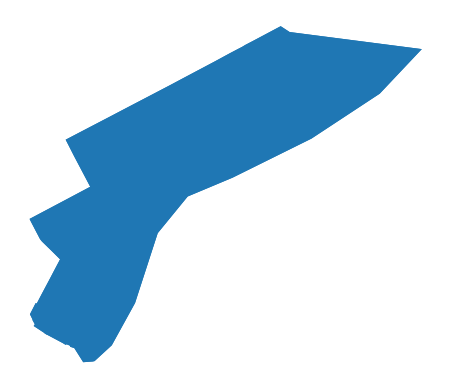

In [10]:
import osmnx as ox

territory_gdf = ox.features_from_place('Санкт-Петербург', tags={'name':'округ № 7'}).to_crs(blocks_gdf.crs) # округ № 7
territory_gdf.plot().set_axis_off()

In [11]:
import networkx as nx

adj_graph = nx.read_graphml('adj_graph.graphml')
nx.relabel_nodes(adj_graph, int, copy=False)

In [12]:
from lu_igi.pygad_optimizer import PygadOptimizer

pygad_optimizer = PygadOptimizer(blocks_gdf, adj_graph)

In [13]:
target_lu_shares = {
    LandUse.RESIDENTIAL : 0.5,
    LandUse.RECREATION : 0.3,
    LandUse.BUSINESS : 0.2
}

blocks_gdf, ga_instance = pygad_optimizer.run(territory_gdf, target_lu_shares, saturation=10, num_generations=100, sol_per_pop=10, mutation_probability=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]/home/vasilstar/lu-igi/.venv/lib/python3.10/site-packages/pygad/pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")
100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


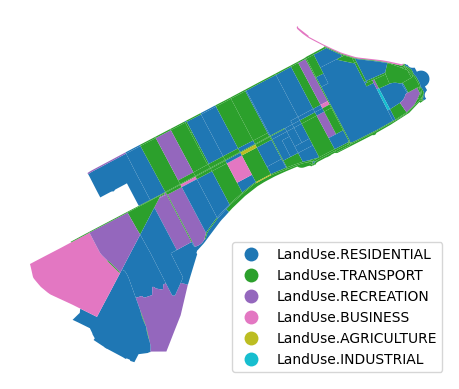

In [14]:
blocks_gdf.plot(column='assigned_land_use', legend=True, legend_kwds={'loc': 'lower right'}).set_axis_off()

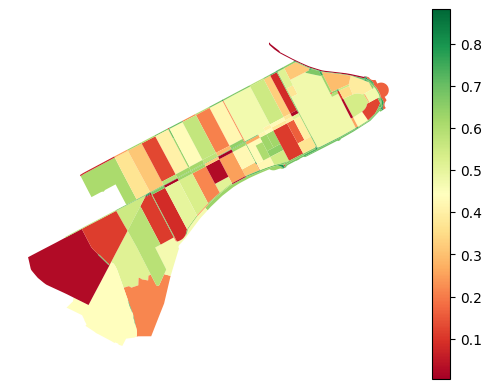

In [15]:
blocks_gdf['probability'] = blocks_gdf.apply(lambda s : s['probabilities'].get(s['assigned_land_use']), axis=1)
blocks_gdf.plot(column='probability', cmap='RdYlGn', legend=True).set_axis_off()

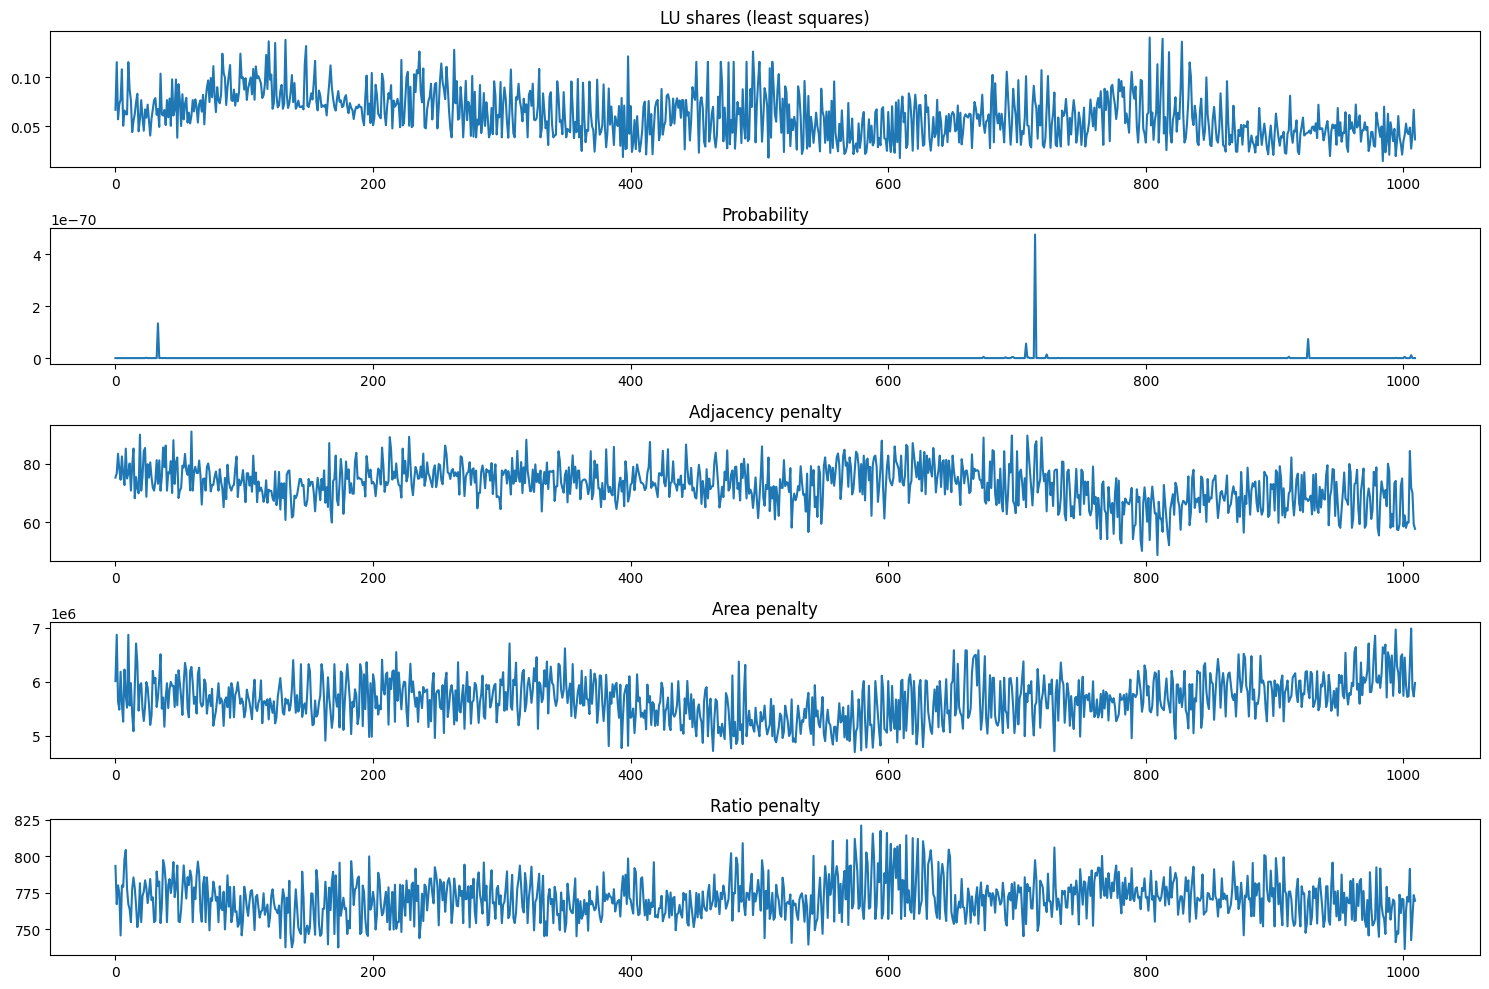

In [16]:
PygadOptimizer.plot_fitness(ga_instance)